In [ ]:
#Step 1: Import Libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [ ]:
# Step 2: Load Dataset 
df = pd.read_excel("OnlineRetail.xlsx")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
# Step 3: Data Cleaning 

df = df.dropna(subset=['CustomerID'])

df = df[df['Quantity'] > 0]

df['TotalSales'] = df['Quantity'] * df['UnitPrice']

df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
TotalSales     0
dtype: int64

In [ ]:
# Step 4: Define Reference Date

reference_date = df['InvoiceDate'].max() + dt.timedelta(days=1)


rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  
    'InvoiceNo': 'nunique',                                  
    'TotalSales': 'sum'                                   
})

# Rename columns
rfm.rename(columns={'InvoiceDate': 'Recency',
                    'InvoiceNo': 'Frequency',
                    'TotalSales': 'Monetary'}, inplace=True)

rfm.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


In [ ]:
# Step 6: Assign RFM Scores 
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])   # Lower recency = better
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method="first"), 5, labels=[1,2,3,4,5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])

# Combine RFM scores
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm['RFM_Score'] = rfm[['R_Score','F_Score','M_Score']].astype(int).sum(axis=1)

rfm.head()


,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12346.0,326,1,77183.60,1,1,5,115,7
12347.0,2,7,4310.00,5,5,5,555,15
12348.0,75,4,1797.24,2,4,4,244,10
12349.0,19,1,1757.55,4,1,4,414,9
12350.0,310,1,334.40,1,1,2,112,4


In [ ]:
# Step 7: Define Customer Segments
def segment_customer(score):
    if score >= 12:
        return "Champions"
    elif score >= 9:
        return "Loyal Customers"
    elif score >= 6:
        return "Potential Loyalists"
    else:
        return "At Risk"
    
rfm['Segment'] = rfm['RFM_Score'].apply(segment_customer)

rfm['Segment'].value_counts()


Segment
Champions              1256
Potential Loyalists    1178
Loyal Customers        1022
At Risk                 883
Name: count, dtype: int64

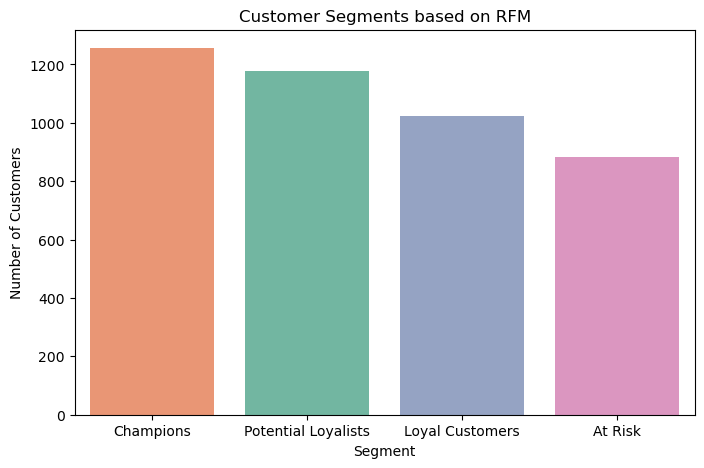

In [ ]:
# Step 8: Visualize Segments
plt.figure(figsize=(8,5))

sns.countplot(
    x='Segment',
    hue='Segment',   # tie colors to segment
    data=rfm,
    order=rfm['Segment'].value_counts().index,
    palette="Set2",
    legend=False     # remove redundant legend
)

plt.title("Customer Segments based on RFM")
plt.xlabel("Segment")
plt.ylabel("Number of Customers")
plt.show()


C:\Users\malak\AppData\Local\Temp\ipykernel_24436\2927038134.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rfm_heatmap = rfm.groupby(['R_Score','F_Score']).size().unstack(fill_value=0)


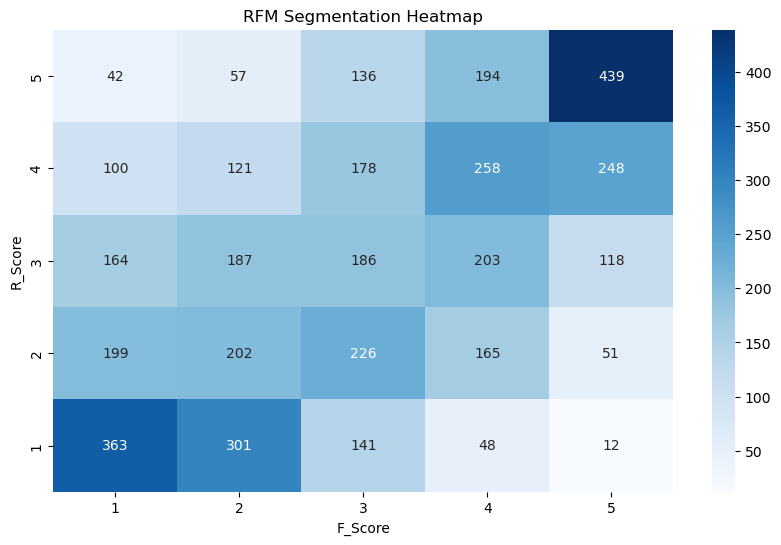

In [ ]:
# Step 9 (Bonus): Heatmap of RFM Segments
rfm_heatmap = rfm.groupby(['R_Score','F_Score']).size().unstack(fill_value=0)
plt.figure(figsize=(10,6))
sns.heatmap(rfm_heatmap, cmap="Blues", annot=True, fmt='g')
plt.title("RFM Segmentation Heatmap")
plt.show()


In [ ]:
# Step 10: Simple Marketing Ideas 
segment_ideas = {
    "Champions": "Reward them with discounts, early access, and loyalty perks.",
    "Loyal Customers": "Keep them engaged with newsletters and personalized offers.",
    "Potential Loyalists": "Nurture them with special promotions to turn them into Champions.",
    "At Risk": "Re-engage with win-back campaigns or discounts."
}

for seg, idea in segment_ideas.items():
    print(f"{seg}: {idea}")


Champions: Reward them with discounts, early access, and loyalty perks.
Loyal Customers: Keep them engaged with newsletters and personalized offers.
Potential Loyalists: Nurture them with special promotions to turn them into Champions.
At Risk: Re-engage with win-back campaigns or discounts.
